In [1]:
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
files =  glob.glob("./*.dat")

In [3]:
len(files)

544

In [4]:
def carrega_dados(filename, n_particulas=1.0e07):
    data = {
        'Elow(eV)' : [],
        'Emiddle(eV)' : [],
        'counts(1/eV/hist)' : [],
        '+-2sigma':[],
        'nbin' : []
    }

    linha_de_dados = False
    with open(filename, "r") as f:
        for line in f:
            if line[0] == '#':
                linha_de_dados = False
            else:
                linha_de_dados = True

            if linha_de_dados:
                aux = line.split(' ')
                if len(aux) == 2:
                    break

                data['Elow(eV)'].append(np.fromstring(aux[2], dtype=np.float64, sep=',')[0])
                data['Emiddle(eV)'].append(np.fromstring(aux[4], dtype=np.float64, sep=',')[0])
                q = np.fromstring(aux[6], dtype=np.float64, sep=',')[0]
                data['counts(1/eV/hist)'].append(q)
                data['+-2sigma'].append(np.fromstring(aux[8], dtype=np.float64, sep=',')[0])
                nbin = np.fromstring(aux[9], dtype=np.int, sep=',')[0]
                data['nbin'].append(nbin)      

    df = pd.DataFrame.from_dict(data)
    df['counts'] = df['counts(1/eV/hist)'].values * n_particulas * 1 / ((df['Elow(eV)'].shift(-1).fillna(0) - df['Elow(eV)']) / df['nbin'])
    df['counts'] = df['counts']#.astype(np.uint8)
    df['counts'][0:20] = 0
    df['E'] = df['Elow(eV)'] / 1e3
    return df.loc[0:16383]

In [48]:
energias_iniciais_multicanal = ['0-01.dat', '5-0.dat', '10-0.dat', '30-0.dat', '40-0.dat']
energias_iniciais_multicanal = ['0-01.dat']

In [49]:
nomes_nuclideos = {'Am-241': 0,
  'Ba-133': 1,
  'Cd-109': 2,
  'Co-57': 3,
  'Co-60': 4,
  'Cs-137': 5,
  'Eu-152': 6,
  'Mn-54': 7,
  'Na-24': 8,
  'Pb-210': 9}

binarizer = MultiLabelBinarizer()
binarizer.fit([list(nomes_nuclideos.keys())])
binarizer.classes_

array(['Am-241', 'Ba-133', 'Cd-109', 'Co-57', 'Co-60', 'Cs-137', 'Eu-152',
       'Mn-54', 'Na-24', 'Pb-210'], dtype=object)

In [50]:
# Cd-109_41cm_1-0e08estories_0-01.dat
dados = []
dados_por_energia_inicial_multicanal = dict()

for energia_inicial_multicanal in energias_iniciais_multicanal:
    dados_por_energia_inicial_multicanal[energia_inicial_multicanal] = []
    
    for file_ in tqdm_notebook(files):
        
        if not file_.endswith(energia_inicial_multicanal):
            continue
        
        partes = file_[2:].split('_')
        nuclideo = partes[0]
        n_particulas = float(partes[2].replace('estories','').replace('-','.'))
        dados_ = carrega_dados(file_, n_particulas)
        dados_por_energia_inicial_multicanal[energia_inicial_multicanal].append({'X' : dados_.counts.values,
                                                                                'y': binarizer.transform([[nuclideo]])})

/home/andre/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [51]:
def gera_imagem_combinada(dicionario_imagens, n_combinacoes=3):
    assert n_combinacoes <= 10, "No máximo 10 combinações"

    aux = np.random.choice(dicionario_imagens, n_combinacoes, replace=False)
    #print(aux)
    labels = np.sum([x['y'] for x in aux], axis=0)
    values = np.sum([x['X'] for x in aux], axis=0)
    
    while np.max(labels) > 1: # temos nuclideo repetido
        labels[0][np.argmax(labels[0])] = 1
    
    return values, labels

## Gera espectros com mais de um radionuclideo

In [52]:
n_combinacoes = [2, 3, 4]
novos_dados = dict()

for key in energias_iniciais_multicanal:
    novos_dados[key] = []
    for n_ in n_combinacoes:
        for i in range(500):
            values, labels = gera_imagem_combinada(dados_por_energia_inicial_multicanal[key],
                                                  n_)
            novos_dados[key].append({'X' : values, 'y': labels})

In [53]:
X = []
y = []

In [54]:
for key in energias_iniciais_multicanal:
    for item in dados_por_energia_inicial_multicanal[key]:
        X.append(list(item.values())[0].reshape((128, 128)))
        y.append(item['y'][0])

In [55]:
for key in energias_iniciais_multicanal:
    for item in novos_dados[key]:
        X.append(list(item.values())[0].reshape((128, 128)))
        y.append(item['y'][0])

In [56]:
len(X), len(y)

(1610, 1610)

# Modelo

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
# Para o Modelo
import tensorflow as tf
import keras
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.optimizers import *
from keras.callbacks import *
from keras.metrics import top_k_categorical_accuracy
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

/home/andre/.conda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30,
                                                    random_state=42)

In [58]:
len(X_train), len(X_test)

(1127, 483)

In [17]:
def add_noise(image):
    #if random.random() <= 0.5:
    #    return image.reshape((128, 128, 1))
    row, col = image.shape
    mean = np.mean(image)
    var = 0.1 #random.random() #
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, (row,col))
    gauss = gauss.reshape(row, col)
    noisy = image + gauss
    return noisy.reshape((128, 128, 1)) #/ np.max(noisy) # normalizando pelo valor máximo

In [18]:
from keras.utils import Sequence

In [19]:
class EspectraSequence(Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array([x.reshape((128, 128, 1)) for x in batch_x]), np.array(batch_y)

In [59]:
s = EspectraSequence(X_train, y_train, batch_size=8)

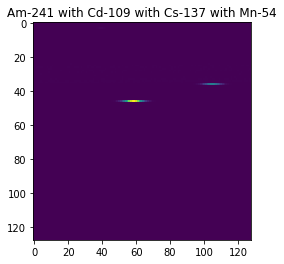

In [60]:
a, b = s[2]
plt.imshow(a[0].reshape((128, 128)))
plt.title(" with ".join(binarizer.inverse_transform(np.array([b[0]]))[0]))
plt.show()

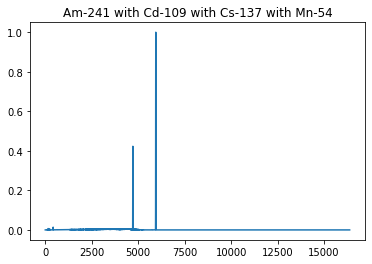

In [62]:
plt.title(" with ".join(binarizer.inverse_transform(np.array([b[0]]))[0]))
plt.plot(a[0].reshape(-1))
plt.show()

In [105]:
learning_rate = 1e-4
epochs = 2500
batch_size = 8
steps_per_epoch = len(X_train) // batch_size + 1
validation_steps = len(X_test) // batch_size + 1

In [65]:
def accuracy_score_wrapper(label, pred):
    threshold = .85
    label = (label >= threshold).astype(np.uint8)
    pred = (pred >= threshold).astype(np.uint8)
    return np.float32(accuracy_score(label, pred))

def my_accuracy_score(label, pred):
    metric_value = tf.py_func(accuracy_score_wrapper, [label, pred], tf.float32)
    return metric_value

In [104]:
"""
K.clear_session()

import keras

input_ = keras.layers.Input(shape=(128, 128, 1))
x = keras.layers.BatchNormalization()(input_)

x = keras.layers.Conv2D(8, (2,2), strides=(1, 1))(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = keras.layers.Conv2D(16, (2,2), strides=(1, 1))(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = keras.layers.Conv2D(32, (2,2), strides=(1, 1))(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = keras.layers.Flatten(name='flatten')(x)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dense(10, activation='sigmoid', name="predictions")(x)

model = keras.models.Model(input_, x)
model.summary()
"""

K.clear_session()
import keras
vgg_model = VGG19(include_top=False,
                  weights=None,
                  input_shape=(128, 128, 1),
                  classes=10)

x = keras.layers.Flatten()(vgg_model.output)
#x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(4096, activation='relu')(x)
#x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(4096, activation='relu')(x)

x = keras.layers.Dense(10, activation='sigmoid', name="predictions")(x)

model = keras.models.Model(vgg_model.input, x)
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [106]:
opt = SGD(lr=learning_rate, nesterov=True, momentum=0.9)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=[my_accuracy_score, 'accuracy'])

In [107]:
gerador_treino = EspectraSequence(X_train, y_train, batch_size=batch_size)
#gerador_imagens(X_train, y_train, batch_size=batch_size)

gerador_validacao = EspectraSequence(X_test, y_test, batch_size=batch_size)
#gerador_imagens(X_test, y_test, batch_size=batch_size)

callbacks = []

hist = model.fit_generator(generator=gerador_treino,
                           steps_per_epoch=steps_per_epoch,
                           epochs=epochs,
                           verbose=2,
                           callbacks=callbacks,
                           validation_data=gerador_validacao, #(x_train_val, y_train_val),
                           validation_steps=validation_steps,
                           shuffle=True)


Epoch 1/2500
 - 13s - loss: 0.6081 - my_accuracy_score: 0.0115 - acc: 0.7818 - val_loss: 0.5739 - val_my_accuracy_score: 0.0041 - val_acc: 0.8375
Epoch 2/2500
 - 11s - loss: 0.5657 - my_accuracy_score: 0.0168 - acc: 0.8366 - val_loss: 0.5503 - val_my_accuracy_score: 0.0062 - val_acc: 0.8474
Epoch 3/2500
 - 11s - loss: 0.5492 - my_accuracy_score: 0.0266 - acc: 0.8430 - val_loss: 0.5403 - val_my_accuracy_score: 0.0228 - val_acc: 0.8482
Epoch 4/2500
 - 11s - loss: 0.5382 - my_accuracy_score: 0.0310 - acc: 0.8435 - val_loss: 0.5343 - val_my_accuracy_score: 0.0311 - val_acc: 0.8522
Epoch 5/2500
 - 11s - loss: 0.5331 - my_accuracy_score: 0.0319 - acc: 0.8460 - val_loss: 0.5251 - val_my_accuracy_score: 0.0373 - val_acc: 0.8580
Epoch 6/2500
 - 11s - loss: 0.5242 - my_accuracy_score: 0.0355 - acc: 0.8490 - val_loss: 0.5178 - val_my_accuracy_score: 0.0497 - val_acc: 0.8654
Epoch 7/2500
 - 11s - loss: 0.5196 - my_accuracy_score: 0.0408 - acc: 0.8475 - val_loss: 0.5189 - val_my_accuracy_score: 0.0

Epoch 57/2500
 - 11s - loss: 0.4132 - my_accuracy_score: 0.1093 - acc: 0.8773 - val_loss: 0.4367 - val_my_accuracy_score: 0.1201 - val_acc: 0.8818
Epoch 58/2500
 - 11s - loss: 0.4152 - my_accuracy_score: 0.1101 - acc: 0.8755 - val_loss: 0.4533 - val_my_accuracy_score: 0.1056 - val_acc: 0.8799
Epoch 59/2500
 - 11s - loss: 0.4097 - my_accuracy_score: 0.1145 - acc: 0.8785 - val_loss: 0.4327 - val_my_accuracy_score: 0.1346 - val_acc: 0.8818
Epoch 60/2500
 - 11s - loss: 0.4109 - my_accuracy_score: 0.1120 - acc: 0.8792 - val_loss: 0.4343 - val_my_accuracy_score: 0.1242 - val_acc: 0.8795
Epoch 61/2500
 - 11s - loss: 0.4089 - my_accuracy_score: 0.1146 - acc: 0.8788 - val_loss: 0.4353 - val_my_accuracy_score: 0.1139 - val_acc: 0.8797
Epoch 62/2500
 - 11s - loss: 0.4057 - my_accuracy_score: 0.1188 - acc: 0.8796 - val_loss: 0.4371 - val_my_accuracy_score: 0.1325 - val_acc: 0.8756
Epoch 63/2500
 - 11s - loss: 0.4030 - my_accuracy_score: 0.1225 - acc: 0.8793 - val_loss: 0.4321 - val_my_accuracy_sco

Epoch 113/2500
 - 11s - loss: 0.3295 - my_accuracy_score: 0.1997 - acc: 0.8859 - val_loss: 0.3646 - val_my_accuracy_score: 0.1884 - val_acc: 0.8915
Epoch 114/2500
 - 11s - loss: 0.3327 - my_accuracy_score: 0.1995 - acc: 0.8845 - val_loss: 0.3844 - val_my_accuracy_score: 0.1946 - val_acc: 0.8911
Epoch 115/2500
 - 11s - loss: 0.3251 - my_accuracy_score: 0.1953 - acc: 0.8881 - val_loss: 0.3859 - val_my_accuracy_score: 0.2029 - val_acc: 0.8865
Epoch 116/2500
 - 11s - loss: 0.3252 - my_accuracy_score: 0.2006 - acc: 0.8883 - val_loss: 0.3864 - val_my_accuracy_score: 0.1822 - val_acc: 0.8807
Epoch 117/2500
 - 11s - loss: 0.3235 - my_accuracy_score: 0.1935 - acc: 0.8874 - val_loss: 0.3805 - val_my_accuracy_score: 0.2050 - val_acc: 0.8857
Epoch 118/2500
 - 11s - loss: 0.3241 - my_accuracy_score: 0.2033 - acc: 0.8867 - val_loss: 0.3717 - val_my_accuracy_score: 0.1925 - val_acc: 0.8896
Epoch 119/2500
 - 11s - loss: 0.3216 - my_accuracy_score: 0.2059 - acc: 0.8871 - val_loss: 0.3781 - val_my_accur

Epoch 169/2500
 - 11s - loss: 0.2491 - my_accuracy_score: 0.2591 - acc: 0.9075 - val_loss: 0.3322 - val_my_accuracy_score: 0.2650 - val_acc: 0.9027
Epoch 170/2500
 - 11s - loss: 0.2366 - my_accuracy_score: 0.2832 - acc: 0.9115 - val_loss: 0.3224 - val_my_accuracy_score: 0.2629 - val_acc: 0.9062
Epoch 171/2500
 - 11s - loss: 0.2458 - my_accuracy_score: 0.2680 - acc: 0.9078 - val_loss: 0.3196 - val_my_accuracy_score: 0.2795 - val_acc: 0.9118
Epoch 172/2500
 - 11s - loss: 0.2481 - my_accuracy_score: 0.2628 - acc: 0.9081 - val_loss: 0.3000 - val_my_accuracy_score: 0.2650 - val_acc: 0.9133
Epoch 173/2500
 - 11s - loss: 0.2389 - my_accuracy_score: 0.2680 - acc: 0.9117 - val_loss: 0.3048 - val_my_accuracy_score: 0.2857 - val_acc: 0.9130
Epoch 174/2500
 - 11s - loss: 0.2327 - my_accuracy_score: 0.2893 - acc: 0.9150 - val_loss: 0.3176 - val_my_accuracy_score: 0.2588 - val_acc: 0.8932
Epoch 175/2500
 - 11s - loss: 0.2369 - my_accuracy_score: 0.2733 - acc: 0.9119 - val_loss: 0.3032 - val_my_accur

Epoch 225/2500
 - 11s - loss: 0.1425 - my_accuracy_score: 0.4550 - acc: 0.9508 - val_loss: 0.2316 - val_my_accuracy_score: 0.4099 - val_acc: 0.9331
Epoch 226/2500
 - 11s - loss: 0.1499 - my_accuracy_score: 0.4487 - acc: 0.9450 - val_loss: 0.2434 - val_my_accuracy_score: 0.4534 - val_acc: 0.9437
Epoch 227/2500
 - 11s - loss: 0.1411 - my_accuracy_score: 0.4524 - acc: 0.9483 - val_loss: 0.2244 - val_my_accuracy_score: 0.4431 - val_acc: 0.9439
Epoch 228/2500
 - 11s - loss: 0.1339 - my_accuracy_score: 0.4809 - acc: 0.9530 - val_loss: 0.2089 - val_my_accuracy_score: 0.4265 - val_acc: 0.9391
Epoch 229/2500
 - 11s - loss: 0.1353 - my_accuracy_score: 0.4800 - acc: 0.9529 - val_loss: 0.2238 - val_my_accuracy_score: 0.4472 - val_acc: 0.9387
Epoch 230/2500
 - 11s - loss: 0.1396 - my_accuracy_score: 0.4754 - acc: 0.9512 - val_loss: 0.2084 - val_my_accuracy_score: 0.4389 - val_acc: 0.9455
Epoch 231/2500
 - 11s - loss: 0.1374 - my_accuracy_score: 0.4738 - acc: 0.9520 - val_loss: 0.2236 - val_my_accur

Epoch 281/2500
 - 11s - loss: 0.0737 - my_accuracy_score: 0.6540 - acc: 0.9737 - val_loss: 0.1517 - val_my_accuracy_score: 0.6087 - val_acc: 0.9586
Epoch 282/2500
 - 11s - loss: 0.0733 - my_accuracy_score: 0.6586 - acc: 0.9732 - val_loss: 0.1879 - val_my_accuracy_score: 0.6356 - val_acc: 0.9598
Epoch 283/2500
 - 11s - loss: 0.0729 - my_accuracy_score: 0.6565 - acc: 0.9725 - val_loss: 0.2035 - val_my_accuracy_score: 0.6046 - val_acc: 0.9540
Epoch 284/2500
 - 11s - loss: 0.0662 - my_accuracy_score: 0.6753 - acc: 0.9745 - val_loss: 0.1969 - val_my_accuracy_score: 0.5921 - val_acc: 0.9522
Epoch 285/2500
 - 11s - loss: 0.0687 - my_accuracy_score: 0.6611 - acc: 0.9752 - val_loss: 0.1423 - val_my_accuracy_score: 0.6025 - val_acc: 0.9623
Epoch 286/2500
 - 11s - loss: 0.0734 - my_accuracy_score: 0.6710 - acc: 0.9743 - val_loss: 0.1921 - val_my_accuracy_score: 0.6211 - val_acc: 0.9557
Epoch 287/2500
 - 11s - loss: 0.0738 - my_accuracy_score: 0.6575 - acc: 0.9741 - val_loss: 0.1521 - val_my_accur

Epoch 337/2500
 - 11s - loss: 0.0404 - my_accuracy_score: 0.7976 - acc: 0.9843 - val_loss: 0.1251 - val_my_accuracy_score: 0.6936 - val_acc: 0.9681
Epoch 338/2500
 - 11s - loss: 0.0496 - my_accuracy_score: 0.7818 - acc: 0.9819 - val_loss: 0.1173 - val_my_accuracy_score: 0.6605 - val_acc: 0.9685
Epoch 339/2500
 - 11s - loss: 0.0455 - my_accuracy_score: 0.7781 - acc: 0.9834 - val_loss: 0.1508 - val_my_accuracy_score: 0.6584 - val_acc: 0.9669
Epoch 340/2500
 - 11s - loss: 0.0403 - my_accuracy_score: 0.8029 - acc: 0.9855 - val_loss: 0.1514 - val_my_accuracy_score: 0.7081 - val_acc: 0.9679
Epoch 341/2500
 - 11s - loss: 0.0415 - my_accuracy_score: 0.7976 - acc: 0.9843 - val_loss: 0.1369 - val_my_accuracy_score: 0.7205 - val_acc: 0.9692
Epoch 342/2500
 - 11s - loss: 0.0420 - my_accuracy_score: 0.7969 - acc: 0.9850 - val_loss: 0.1521 - val_my_accuracy_score: 0.6853 - val_acc: 0.9667
Epoch 343/2500
 - 11s - loss: 0.0375 - my_accuracy_score: 0.8100 - acc: 0.9861 - val_loss: 0.1274 - val_my_accur

Epoch 393/2500
 - 11s - loss: 0.0252 - my_accuracy_score: 0.8650 - acc: 0.9907 - val_loss: 0.1519 - val_my_accuracy_score: 0.7081 - val_acc: 0.9694
Epoch 394/2500
 - 11s - loss: 0.0254 - my_accuracy_score: 0.8660 - acc: 0.9906 - val_loss: 0.1175 - val_my_accuracy_score: 0.7433 - val_acc: 0.9735
Epoch 395/2500
 - 11s - loss: 0.0245 - my_accuracy_score: 0.8747 - acc: 0.9908 - val_loss: 0.1402 - val_my_accuracy_score: 0.7350 - val_acc: 0.9731
Epoch 396/2500
 - 11s - loss: 0.0287 - my_accuracy_score: 0.8571 - acc: 0.9895 - val_loss: 0.1665 - val_my_accuracy_score: 0.7391 - val_acc: 0.9714
Epoch 397/2500
 - 11s - loss: 0.0247 - my_accuracy_score: 0.8766 - acc: 0.9907 - val_loss: 0.1477 - val_my_accuracy_score: 0.7288 - val_acc: 0.9667
Epoch 398/2500
 - 11s - loss: 0.0260 - my_accuracy_score: 0.8598 - acc: 0.9905 - val_loss: 0.1354 - val_my_accuracy_score: 0.7412 - val_acc: 0.9696
Epoch 399/2500
 - 11s - loss: 0.0256 - my_accuracy_score: 0.8694 - acc: 0.9908 - val_loss: 0.1423 - val_my_accur

Epoch 449/2500
 - 11s - loss: 0.0189 - my_accuracy_score: 0.8908 - acc: 0.9934 - val_loss: 0.1336 - val_my_accuracy_score: 0.7474 - val_acc: 0.9710
Epoch 450/2500
 - 11s - loss: 0.0183 - my_accuracy_score: 0.8951 - acc: 0.9932 - val_loss: 0.1690 - val_my_accuracy_score: 0.7578 - val_acc: 0.9696
Epoch 451/2500
 - 11s - loss: 0.0205 - my_accuracy_score: 0.8917 - acc: 0.9924 - val_loss: 0.1301 - val_my_accuracy_score: 0.7640 - val_acc: 0.9749
Epoch 452/2500
 - 11s - loss: 0.0202 - my_accuracy_score: 0.8951 - acc: 0.9926 - val_loss: 0.1248 - val_my_accuracy_score: 0.7702 - val_acc: 0.9756
Epoch 453/2500
 - 11s - loss: 0.0192 - my_accuracy_score: 0.8935 - acc: 0.9934 - val_loss: 0.1343 - val_my_accuracy_score: 0.7619 - val_acc: 0.9708
Epoch 454/2500
 - 11s - loss: 0.0196 - my_accuracy_score: 0.8945 - acc: 0.9928 - val_loss: 0.1354 - val_my_accuracy_score: 0.7764 - val_acc: 0.9733
Epoch 455/2500
 - 11s - loss: 0.0210 - my_accuracy_score: 0.8863 - acc: 0.9917 - val_loss: 0.1657 - val_my_accur

Epoch 505/2500
 - 11s - loss: 0.0168 - my_accuracy_score: 0.9210 - acc: 0.9936 - val_loss: 0.1471 - val_my_accuracy_score: 0.7516 - val_acc: 0.9696
Epoch 506/2500
 - 11s - loss: 0.0166 - my_accuracy_score: 0.9122 - acc: 0.9935 - val_loss: 0.1654 - val_my_accuracy_score: 0.7785 - val_acc: 0.9764
Epoch 507/2500
 - 11s - loss: 0.0180 - my_accuracy_score: 0.9113 - acc: 0.9934 - val_loss: 0.1678 - val_my_accuracy_score: 0.7495 - val_acc: 0.9689
Epoch 508/2500
 - 11s - loss: 0.0163 - my_accuracy_score: 0.9146 - acc: 0.9933 - val_loss: 0.1402 - val_my_accuracy_score: 0.7805 - val_acc: 0.9760
Epoch 509/2500
 - 11s - loss: 0.0144 - my_accuracy_score: 0.9210 - acc: 0.9946 - val_loss: 0.1389 - val_my_accuracy_score: 0.7826 - val_acc: 0.9772
Epoch 510/2500
 - 11s - loss: 0.0141 - my_accuracy_score: 0.9236 - acc: 0.9945 - val_loss: 0.1453 - val_my_accuracy_score: 0.7930 - val_acc: 0.9758
Epoch 511/2500
 - 11s - loss: 0.0138 - my_accuracy_score: 0.9183 - acc: 0.9949 - val_loss: 0.1535 - val_my_accur

Epoch 561/2500
 - 11s - loss: 0.0118 - my_accuracy_score: 0.9386 - acc: 0.9951 - val_loss: 0.1082 - val_my_accuracy_score: 0.7826 - val_acc: 0.9762
Epoch 562/2500
 - 11s - loss: 0.0144 - my_accuracy_score: 0.9317 - acc: 0.9949 - val_loss: 0.1462 - val_my_accuracy_score: 0.7640 - val_acc: 0.9696
Epoch 563/2500
 - 11s - loss: 0.0133 - my_accuracy_score: 0.9316 - acc: 0.9952 - val_loss: 0.1683 - val_my_accuracy_score: 0.7578 - val_acc: 0.9725
Epoch 564/2500
 - 11s - loss: 0.0140 - my_accuracy_score: 0.9309 - acc: 0.9947 - val_loss: 0.1356 - val_my_accuracy_score: 0.7702 - val_acc: 0.9737
Epoch 565/2500
 - 11s - loss: 0.0114 - my_accuracy_score: 0.9369 - acc: 0.9956 - val_loss: 0.1490 - val_my_accuracy_score: 0.7909 - val_acc: 0.9768
Epoch 566/2500
 - 11s - loss: 0.0151 - my_accuracy_score: 0.9238 - acc: 0.9941 - val_loss: 0.1188 - val_my_accuracy_score: 0.7847 - val_acc: 0.9772
Epoch 567/2500
 - 11s - loss: 0.0149 - my_accuracy_score: 0.9282 - acc: 0.9945 - val_loss: 0.1294 - val_my_accur

Epoch 617/2500
 - 11s - loss: 0.0111 - my_accuracy_score: 0.9468 - acc: 0.9957 - val_loss: 0.1411 - val_my_accuracy_score: 0.7702 - val_acc: 0.9741
Epoch 618/2500
 - 11s - loss: 0.0117 - my_accuracy_score: 0.9415 - acc: 0.9951 - val_loss: 0.1328 - val_my_accuracy_score: 0.7764 - val_acc: 0.9749
Epoch 619/2500
 - 11s - loss: 0.0107 - my_accuracy_score: 0.9433 - acc: 0.9957 - val_loss: 0.1377 - val_my_accuracy_score: 0.7805 - val_acc: 0.9766
Epoch 620/2500
 - 11s - loss: 0.0099 - my_accuracy_score: 0.9449 - acc: 0.9960 - val_loss: 0.1258 - val_my_accuracy_score: 0.7805 - val_acc: 0.9756
Epoch 621/2500
 - 11s - loss: 0.0090 - my_accuracy_score: 0.9548 - acc: 0.9964 - val_loss: 0.1430 - val_my_accuracy_score: 0.7743 - val_acc: 0.9735
Epoch 622/2500
 - 11s - loss: 0.0116 - my_accuracy_score: 0.9378 - acc: 0.9952 - val_loss: 0.1230 - val_my_accuracy_score: 0.7619 - val_acc: 0.9723
Epoch 623/2500
 - 11s - loss: 0.0105 - my_accuracy_score: 0.9433 - acc: 0.9951 - val_loss: 0.1436 - val_my_accur

Epoch 673/2500
 - 11s - loss: 0.0087 - my_accuracy_score: 0.9566 - acc: 0.9964 - val_loss: 0.1381 - val_my_accuracy_score: 0.7743 - val_acc: 0.9760
Epoch 674/2500
 - 11s - loss: 0.0090 - my_accuracy_score: 0.9566 - acc: 0.9964 - val_loss: 0.1383 - val_my_accuracy_score: 0.7888 - val_acc: 0.9764
Epoch 675/2500
 - 11s - loss: 0.0094 - my_accuracy_score: 0.9548 - acc: 0.9964 - val_loss: 0.1390 - val_my_accuracy_score: 0.7847 - val_acc: 0.9741
Epoch 676/2500
 - 11s - loss: 0.0096 - my_accuracy_score: 0.9539 - acc: 0.9957 - val_loss: 0.1422 - val_my_accuracy_score: 0.7867 - val_acc: 0.9760
Epoch 677/2500
 - 11s - loss: 0.0119 - my_accuracy_score: 0.9468 - acc: 0.9959 - val_loss: 0.1358 - val_my_accuracy_score: 0.7723 - val_acc: 0.9727
Epoch 678/2500
 - 11s - loss: 0.0118 - my_accuracy_score: 0.9468 - acc: 0.9939 - val_loss: 0.1523 - val_my_accuracy_score: 0.7660 - val_acc: 0.9741
Epoch 679/2500
 - 11s - loss: 0.0125 - my_accuracy_score: 0.9450 - acc: 0.9946 - val_loss: 0.1658 - val_my_accur

Epoch 729/2500
 - 11s - loss: 0.0158 - my_accuracy_score: 0.9362 - acc: 0.9943 - val_loss: 0.1637 - val_my_accuracy_score: 0.7888 - val_acc: 0.9756
Epoch 730/2500
 - 11s - loss: 0.0120 - my_accuracy_score: 0.9477 - acc: 0.9952 - val_loss: 0.1393 - val_my_accuracy_score: 0.7805 - val_acc: 0.9739
Epoch 731/2500
 - 11s - loss: 0.0082 - my_accuracy_score: 0.9557 - acc: 0.9967 - val_loss: 0.1651 - val_my_accuracy_score: 0.7950 - val_acc: 0.9770
Epoch 732/2500
 - 11s - loss: 0.0117 - my_accuracy_score: 0.9430 - acc: 0.9963 - val_loss: 0.1063 - val_my_accuracy_score: 0.7826 - val_acc: 0.9766
Epoch 733/2500
 - 11s - loss: 0.0123 - my_accuracy_score: 0.9415 - acc: 0.9953 - val_loss: 0.1235 - val_my_accuracy_score: 0.7723 - val_acc: 0.9737
Epoch 734/2500
 - 11s - loss: 0.0094 - my_accuracy_score: 0.9493 - acc: 0.9960 - val_loss: 0.1307 - val_my_accuracy_score: 0.7743 - val_acc: 0.9752
Epoch 735/2500
 - 11s - loss: 0.0085 - my_accuracy_score: 0.9592 - acc: 0.9965 - val_loss: 0.1434 - val_my_accur

Epoch 785/2500
 - 11s - loss: 0.0072 - my_accuracy_score: 0.9610 - acc: 0.9971 - val_loss: 0.1406 - val_my_accuracy_score: 0.7660 - val_acc: 0.9762
Epoch 786/2500
 - 11s - loss: 0.0094 - my_accuracy_score: 0.9530 - acc: 0.9963 - val_loss: 0.1347 - val_my_accuracy_score: 0.7805 - val_acc: 0.9781
Epoch 787/2500
 - 11s - loss: 0.0091 - my_accuracy_score: 0.9601 - acc: 0.9965 - val_loss: 0.1369 - val_my_accuracy_score: 0.7888 - val_acc: 0.9768
Epoch 788/2500
 - 11s - loss: 0.0074 - my_accuracy_score: 0.9583 - acc: 0.9970 - val_loss: 0.1308 - val_my_accuracy_score: 0.7640 - val_acc: 0.9752
Epoch 789/2500
 - 11s - loss: 0.0085 - my_accuracy_score: 0.9601 - acc: 0.9965 - val_loss: 0.1524 - val_my_accuracy_score: 0.7743 - val_acc: 0.9725
Epoch 790/2500
 - 11s - loss: 0.0085 - my_accuracy_score: 0.9628 - acc: 0.9963 - val_loss: 0.1270 - val_my_accuracy_score: 0.7723 - val_acc: 0.9758
Epoch 791/2500
 - 11s - loss: 0.0078 - my_accuracy_score: 0.9592 - acc: 0.9968 - val_loss: 0.1493 - val_my_accur

Epoch 841/2500
 - 11s - loss: 0.0068 - my_accuracy_score: 0.9654 - acc: 0.9976 - val_loss: 0.1574 - val_my_accuracy_score: 0.7847 - val_acc: 0.9781
Epoch 842/2500
 - 11s - loss: 0.0070 - my_accuracy_score: 0.9637 - acc: 0.9967 - val_loss: 0.1392 - val_my_accuracy_score: 0.7971 - val_acc: 0.9783
Epoch 843/2500
 - 11s - loss: 0.0072 - my_accuracy_score: 0.9707 - acc: 0.9971 - val_loss: 0.1245 - val_my_accuracy_score: 0.8033 - val_acc: 0.9772
Epoch 844/2500
 - 11s - loss: 0.0078 - my_accuracy_score: 0.9592 - acc: 0.9972 - val_loss: 0.1399 - val_my_accuracy_score: 0.7971 - val_acc: 0.9766
Epoch 845/2500
 - 11s - loss: 0.0064 - my_accuracy_score: 0.9654 - acc: 0.9974 - val_loss: 0.1376 - val_my_accuracy_score: 0.8033 - val_acc: 0.9774
Epoch 846/2500
 - 11s - loss: 0.0059 - my_accuracy_score: 0.9707 - acc: 0.9976 - val_loss: 0.1369 - val_my_accuracy_score: 0.7723 - val_acc: 0.9754
Epoch 847/2500
 - 11s - loss: 0.0067 - my_accuracy_score: 0.9707 - acc: 0.9972 - val_loss: 0.1471 - val_my_accur

Epoch 897/2500
 - 11s - loss: 0.0068 - my_accuracy_score: 0.9654 - acc: 0.9967 - val_loss: 0.1332 - val_my_accuracy_score: 0.8095 - val_acc: 0.9789
Epoch 898/2500
 - 11s - loss: 0.0055 - my_accuracy_score: 0.9690 - acc: 0.9976 - val_loss: 0.1520 - val_my_accuracy_score: 0.7847 - val_acc: 0.9776
Epoch 899/2500
 - 11s - loss: 0.0072 - my_accuracy_score: 0.9637 - acc: 0.9967 - val_loss: 0.1157 - val_my_accuracy_score: 0.7950 - val_acc: 0.9787
Epoch 900/2500
 - 11s - loss: 0.0069 - my_accuracy_score: 0.9672 - acc: 0.9971 - val_loss: 0.1145 - val_my_accuracy_score: 0.7950 - val_acc: 0.9768
Epoch 901/2500
 - 11s - loss: 0.0062 - my_accuracy_score: 0.9690 - acc: 0.9976 - val_loss: 0.1369 - val_my_accuracy_score: 0.7785 - val_acc: 0.9774
Epoch 902/2500
 - 11s - loss: 0.0071 - my_accuracy_score: 0.9654 - acc: 0.9966 - val_loss: 0.1530 - val_my_accuracy_score: 0.7805 - val_acc: 0.9772
Epoch 903/2500
 - 11s - loss: 0.0070 - my_accuracy_score: 0.9681 - acc: 0.9974 - val_loss: 0.1489 - val_my_accur

Epoch 953/2500
 - 11s - loss: 0.0056 - my_accuracy_score: 0.9645 - acc: 0.9973 - val_loss: 0.1351 - val_my_accuracy_score: 0.7992 - val_acc: 0.9791
Epoch 954/2500
 - 11s - loss: 0.0058 - my_accuracy_score: 0.9663 - acc: 0.9979 - val_loss: 0.1378 - val_my_accuracy_score: 0.7826 - val_acc: 0.9776
Epoch 955/2500
 - 11s - loss: 0.0061 - my_accuracy_score: 0.9688 - acc: 0.9973 - val_loss: 0.1240 - val_my_accuracy_score: 0.7950 - val_acc: 0.9785
Epoch 956/2500
 - 11s - loss: 0.0073 - my_accuracy_score: 0.9618 - acc: 0.9970 - val_loss: 0.1413 - val_my_accuracy_score: 0.8033 - val_acc: 0.9756
Epoch 957/2500
 - 11s - loss: 0.0059 - my_accuracy_score: 0.9734 - acc: 0.9969 - val_loss: 0.1378 - val_my_accuracy_score: 0.7909 - val_acc: 0.9745
Epoch 958/2500
 - 11s - loss: 0.0056 - my_accuracy_score: 0.9707 - acc: 0.9974 - val_loss: 0.1202 - val_my_accuracy_score: 0.8012 - val_acc: 0.9791
Epoch 959/2500
 - 11s - loss: 0.0050 - my_accuracy_score: 0.9690 - acc: 0.9980 - val_loss: 0.1340 - val_my_accur

Epoch 1009/2500
 - 11s - loss: 0.0056 - my_accuracy_score: 0.9699 - acc: 0.9977 - val_loss: 0.1412 - val_my_accuracy_score: 0.7785 - val_acc: 0.9737
Epoch 1010/2500
 - 11s - loss: 0.0071 - my_accuracy_score: 0.9690 - acc: 0.9971 - val_loss: 0.1278 - val_my_accuracy_score: 0.7764 - val_acc: 0.9752
Epoch 1011/2500
 - 11s - loss: 0.0062 - my_accuracy_score: 0.9725 - acc: 0.9973 - val_loss: 0.1272 - val_my_accuracy_score: 0.7971 - val_acc: 0.9778
Epoch 1012/2500
 - 11s - loss: 0.0058 - my_accuracy_score: 0.9681 - acc: 0.9973 - val_loss: 0.1252 - val_my_accuracy_score: 0.7888 - val_acc: 0.9756
Epoch 1013/2500
 - 11s - loss: 0.0060 - my_accuracy_score: 0.9672 - acc: 0.9975 - val_loss: 0.1333 - val_my_accuracy_score: 0.7950 - val_acc: 0.9770
Epoch 1014/2500
 - 11s - loss: 0.0062 - my_accuracy_score: 0.9663 - acc: 0.9972 - val_loss: 0.1314 - val_my_accuracy_score: 0.7930 - val_acc: 0.9789
Epoch 1015/2500
 - 11s - loss: 0.0053 - my_accuracy_score: 0.9707 - acc: 0.9978 - val_loss: 0.1468 - val_m

Epoch 1064/2500
 - 11s - loss: 0.0043 - my_accuracy_score: 0.9743 - acc: 0.9983 - val_loss: 0.1511 - val_my_accuracy_score: 0.7723 - val_acc: 0.9749
Epoch 1065/2500
 - 11s - loss: 0.0048 - my_accuracy_score: 0.9787 - acc: 0.9983 - val_loss: 0.1540 - val_my_accuracy_score: 0.7909 - val_acc: 0.9762
Epoch 1066/2500
 - 11s - loss: 0.0052 - my_accuracy_score: 0.9743 - acc: 0.9980 - val_loss: 0.1432 - val_my_accuracy_score: 0.7950 - val_acc: 0.9781
Epoch 1067/2500
 - 11s - loss: 0.0062 - my_accuracy_score: 0.9681 - acc: 0.9973 - val_loss: 0.1300 - val_my_accuracy_score: 0.7909 - val_acc: 0.9781
Epoch 1068/2500
 - 11s - loss: 0.0051 - my_accuracy_score: 0.9681 - acc: 0.9976 - val_loss: 0.1493 - val_my_accuracy_score: 0.8054 - val_acc: 0.9770
Epoch 1069/2500
 - 11s - loss: 0.0061 - my_accuracy_score: 0.9662 - acc: 0.9981 - val_loss: 0.1501 - val_my_accuracy_score: 0.7805 - val_acc: 0.9758
Epoch 1070/2500
 - 11s - loss: 0.0049 - my_accuracy_score: 0.9725 - acc: 0.9979 - val_loss: 0.1347 - val_m

Epoch 1119/2500
 - 11s - loss: 0.0051 - my_accuracy_score: 0.9743 - acc: 0.9980 - val_loss: 0.1516 - val_my_accuracy_score: 0.7826 - val_acc: 0.9776
Epoch 1120/2500
 - 11s - loss: 0.0056 - my_accuracy_score: 0.9671 - acc: 0.9973 - val_loss: 0.1237 - val_my_accuracy_score: 0.8054 - val_acc: 0.9776
Epoch 1121/2500
 - 11s - loss: 0.0060 - my_accuracy_score: 0.9690 - acc: 0.9975 - val_loss: 0.1557 - val_my_accuracy_score: 0.7888 - val_acc: 0.9754
Epoch 1122/2500
 - 11s - loss: 0.0059 - my_accuracy_score: 0.9734 - acc: 0.9973 - val_loss: 0.1461 - val_my_accuracy_score: 0.7930 - val_acc: 0.9778
Epoch 1123/2500
 - 11s - loss: 0.0055 - my_accuracy_score: 0.9690 - acc: 0.9978 - val_loss: 0.1326 - val_my_accuracy_score: 0.7992 - val_acc: 0.9774
Epoch 1124/2500
 - 11s - loss: 0.0051 - my_accuracy_score: 0.9787 - acc: 0.9976 - val_loss: 0.1199 - val_my_accuracy_score: 0.7867 - val_acc: 0.9754
Epoch 1125/2500
 - 11s - loss: 0.0056 - my_accuracy_score: 0.9690 - acc: 0.9981 - val_loss: 0.1312 - val_m

Epoch 1174/2500
 - 11s - loss: 0.0048 - my_accuracy_score: 0.9743 - acc: 0.9976 - val_loss: 0.1338 - val_my_accuracy_score: 0.8054 - val_acc: 0.9778
Epoch 1175/2500
 - 11s - loss: 0.0050 - my_accuracy_score: 0.9725 - acc: 0.9978 - val_loss: 0.1266 - val_my_accuracy_score: 0.8199 - val_acc: 0.9781
Epoch 1176/2500
 - 11s - loss: 0.0048 - my_accuracy_score: 0.9778 - acc: 0.9981 - val_loss: 0.1291 - val_my_accuracy_score: 0.7950 - val_acc: 0.9754
Epoch 1177/2500
 - 11s - loss: 0.0044 - my_accuracy_score: 0.9778 - acc: 0.9979 - val_loss: 0.1497 - val_my_accuracy_score: 0.7971 - val_acc: 0.9772
Epoch 1178/2500
 - 11s - loss: 0.0051 - my_accuracy_score: 0.9707 - acc: 0.9977 - val_loss: 0.1445 - val_my_accuracy_score: 0.8033 - val_acc: 0.9787
Epoch 1179/2500
 - 11s - loss: 0.0047 - my_accuracy_score: 0.9725 - acc: 0.9979 - val_loss: 0.1273 - val_my_accuracy_score: 0.8095 - val_acc: 0.9791
Epoch 1180/2500
 - 11s - loss: 0.0048 - my_accuracy_score: 0.9752 - acc: 0.9982 - val_loss: 0.1255 - val_m

Epoch 1229/2500
 - 11s - loss: 0.0034 - my_accuracy_score: 0.9805 - acc: 0.9988 - val_loss: 0.1531 - val_my_accuracy_score: 0.8012 - val_acc: 0.9768
Epoch 1230/2500
 - 11s - loss: 0.0042 - my_accuracy_score: 0.9770 - acc: 0.9980 - val_loss: 0.1312 - val_my_accuracy_score: 0.7992 - val_acc: 0.9754
Epoch 1231/2500
 - 11s - loss: 0.0044 - my_accuracy_score: 0.9770 - acc: 0.9980 - val_loss: 0.1399 - val_my_accuracy_score: 0.8033 - val_acc: 0.9760
Epoch 1232/2500
 - 11s - loss: 0.0050 - my_accuracy_score: 0.9743 - acc: 0.9980 - val_loss: 0.1512 - val_my_accuracy_score: 0.7826 - val_acc: 0.9752
Epoch 1233/2500
 - 11s - loss: 0.0162 - my_accuracy_score: 0.9326 - acc: 0.9949 - val_loss: 0.1066 - val_my_accuracy_score: 0.8178 - val_acc: 0.9768
Epoch 1234/2500
 - 11s - loss: 0.0090 - my_accuracy_score: 0.9574 - acc: 0.9967 - val_loss: 0.1574 - val_my_accuracy_score: 0.8012 - val_acc: 0.9772
Epoch 1235/2500
 - 11s - loss: 0.0058 - my_accuracy_score: 0.9654 - acc: 0.9973 - val_loss: 0.1333 - val_m

Epoch 1284/2500
 - 11s - loss: 0.0042 - my_accuracy_score: 0.9752 - acc: 0.9978 - val_loss: 0.1452 - val_my_accuracy_score: 0.8033 - val_acc: 0.9793
Epoch 1285/2500
 - 11s - loss: 0.0043 - my_accuracy_score: 0.9770 - acc: 0.9981 - val_loss: 0.1335 - val_my_accuracy_score: 0.7826 - val_acc: 0.9752
Epoch 1286/2500
 - 11s - loss: 0.0046 - my_accuracy_score: 0.9743 - acc: 0.9978 - val_loss: 0.1440 - val_my_accuracy_score: 0.7950 - val_acc: 0.9776
Epoch 1287/2500
 - 11s - loss: 0.0047 - my_accuracy_score: 0.9796 - acc: 0.9979 - val_loss: 0.1264 - val_my_accuracy_score: 0.8116 - val_acc: 0.9781
Epoch 1288/2500
 - 11s - loss: 0.0041 - my_accuracy_score: 0.9770 - acc: 0.9980 - val_loss: 0.1374 - val_my_accuracy_score: 0.8054 - val_acc: 0.9764
Epoch 1289/2500
 - 11s - loss: 0.0049 - my_accuracy_score: 0.9814 - acc: 0.9980 - val_loss: 0.1453 - val_my_accuracy_score: 0.7888 - val_acc: 0.9762
Epoch 1290/2500
 - 11s - loss: 0.0050 - my_accuracy_score: 0.9761 - acc: 0.9980 - val_loss: 0.1232 - val_m

Epoch 1339/2500
 - 11s - loss: 0.0032 - my_accuracy_score: 0.9832 - acc: 0.9980 - val_loss: 0.1325 - val_my_accuracy_score: 0.7909 - val_acc: 0.9785
Epoch 1340/2500
 - 11s - loss: 0.0030 - my_accuracy_score: 0.9805 - acc: 0.9988 - val_loss: 0.1485 - val_my_accuracy_score: 0.7909 - val_acc: 0.9787
Epoch 1341/2500
 - 11s - loss: 0.0052 - my_accuracy_score: 0.9716 - acc: 0.9977 - val_loss: 0.1506 - val_my_accuracy_score: 0.7660 - val_acc: 0.9747
Epoch 1342/2500
 - 11s - loss: 0.0041 - my_accuracy_score: 0.9778 - acc: 0.9980 - val_loss: 0.1367 - val_my_accuracy_score: 0.8137 - val_acc: 0.9793
Epoch 1343/2500
 - 11s - loss: 0.0041 - my_accuracy_score: 0.9716 - acc: 0.9981 - val_loss: 0.1463 - val_my_accuracy_score: 0.8075 - val_acc: 0.9766
Epoch 1344/2500
 - 11s - loss: 0.0037 - my_accuracy_score: 0.9805 - acc: 0.9983 - val_loss: 0.1555 - val_my_accuracy_score: 0.7888 - val_acc: 0.9754
Epoch 1345/2500
 - 11s - loss: 0.0035 - my_accuracy_score: 0.9849 - acc: 0.9986 - val_loss: 0.1207 - val_m

Epoch 1394/2500
 - 11s - loss: 0.0032 - my_accuracy_score: 0.9796 - acc: 0.9988 - val_loss: 0.1387 - val_my_accuracy_score: 0.7930 - val_acc: 0.9760
Epoch 1395/2500
 - 11s - loss: 0.0039 - my_accuracy_score: 0.9840 - acc: 0.9988 - val_loss: 0.1332 - val_my_accuracy_score: 0.8116 - val_acc: 0.9799
Epoch 1396/2500
 - 11s - loss: 0.0033 - my_accuracy_score: 0.9814 - acc: 0.9988 - val_loss: 0.1512 - val_my_accuracy_score: 0.8012 - val_acc: 0.9791
Epoch 1397/2500
 - 11s - loss: 0.0028 - my_accuracy_score: 0.9823 - acc: 0.9986 - val_loss: 0.1334 - val_my_accuracy_score: 0.7950 - val_acc: 0.9783
Epoch 1398/2500
 - 11s - loss: 0.0037 - my_accuracy_score: 0.9823 - acc: 0.9983 - val_loss: 0.1300 - val_my_accuracy_score: 0.8157 - val_acc: 0.9774
Epoch 1399/2500
 - 11s - loss: 0.0033 - my_accuracy_score: 0.9823 - acc: 0.9984 - val_loss: 0.1473 - val_my_accuracy_score: 0.7950 - val_acc: 0.9774
Epoch 1400/2500
 - 11s - loss: 0.0039 - my_accuracy_score: 0.9823 - acc: 0.9987 - val_loss: 0.1477 - val_m

Epoch 1449/2500
 - 11s - loss: 0.0025 - my_accuracy_score: 0.9840 - acc: 0.9991 - val_loss: 0.1428 - val_my_accuracy_score: 0.8116 - val_acc: 0.9783
Epoch 1450/2500
 - 11s - loss: 0.0031 - my_accuracy_score: 0.9832 - acc: 0.9988 - val_loss: 0.1417 - val_my_accuracy_score: 0.8054 - val_acc: 0.9803
Epoch 1451/2500
 - 11s - loss: 0.0032 - my_accuracy_score: 0.9823 - acc: 0.9986 - val_loss: 0.1344 - val_my_accuracy_score: 0.8033 - val_acc: 0.9799
Epoch 1452/2500
 - 11s - loss: 0.0036 - my_accuracy_score: 0.9787 - acc: 0.9987 - val_loss: 0.1557 - val_my_accuracy_score: 0.7992 - val_acc: 0.9774
Epoch 1453/2500
 - 11s - loss: 0.0043 - my_accuracy_score: 0.9814 - acc: 0.9982 - val_loss: 0.1327 - val_my_accuracy_score: 0.7950 - val_acc: 0.9770
Epoch 1454/2500
 - 11s - loss: 0.0029 - my_accuracy_score: 0.9832 - acc: 0.9983 - val_loss: 0.1339 - val_my_accuracy_score: 0.8033 - val_acc: 0.9776
Epoch 1455/2500
 - 11s - loss: 0.0046 - my_accuracy_score: 0.9752 - acc: 0.9981 - val_loss: 0.1470 - val_m

Epoch 1504/2500
 - 11s - loss: 0.0032 - my_accuracy_score: 0.9814 - acc: 0.9988 - val_loss: 0.1556 - val_my_accuracy_score: 0.7992 - val_acc: 0.9772
Epoch 1505/2500
 - 11s - loss: 0.0031 - my_accuracy_score: 0.9832 - acc: 0.9989 - val_loss: 0.1666 - val_my_accuracy_score: 0.7971 - val_acc: 0.9783
Epoch 1506/2500
 - 11s - loss: 0.0028 - my_accuracy_score: 0.9840 - acc: 0.9990 - val_loss: 0.1388 - val_my_accuracy_score: 0.7867 - val_acc: 0.9752
Epoch 1507/2500
 - 11s - loss: 0.0048 - my_accuracy_score: 0.9761 - acc: 0.9980 - val_loss: 0.1490 - val_my_accuracy_score: 0.7971 - val_acc: 0.9741
Epoch 1508/2500
 - 11s - loss: 0.0052 - my_accuracy_score: 0.9743 - acc: 0.9977 - val_loss: 0.1434 - val_my_accuracy_score: 0.8095 - val_acc: 0.9793
Epoch 1509/2500
 - 11s - loss: 0.0049 - my_accuracy_score: 0.9725 - acc: 0.9984 - val_loss: 0.1366 - val_my_accuracy_score: 0.7971 - val_acc: 0.9789
Epoch 1510/2500
 - 11s - loss: 0.0025 - my_accuracy_score: 0.9805 - acc: 0.9992 - val_loss: 0.1454 - val_m

Epoch 1559/2500
 - 11s - loss: 0.0030 - my_accuracy_score: 0.9832 - acc: 0.9987 - val_loss: 0.1423 - val_my_accuracy_score: 0.7930 - val_acc: 0.9760
Epoch 1560/2500
 - 11s - loss: 0.0031 - my_accuracy_score: 0.9787 - acc: 0.9987 - val_loss: 0.1439 - val_my_accuracy_score: 0.7930 - val_acc: 0.9776
Epoch 1561/2500
 - 11s - loss: 0.0044 - my_accuracy_score: 0.9814 - acc: 0.9984 - val_loss: 0.1241 - val_my_accuracy_score: 0.7743 - val_acc: 0.9749
Epoch 1562/2500
 - 11s - loss: 0.0036 - my_accuracy_score: 0.9778 - acc: 0.9986 - val_loss: 0.1258 - val_my_accuracy_score: 0.7971 - val_acc: 0.9772
Epoch 1563/2500
 - 11s - loss: 0.0030 - my_accuracy_score: 0.9840 - acc: 0.9988 - val_loss: 0.1420 - val_my_accuracy_score: 0.7992 - val_acc: 0.9783
Epoch 1564/2500
 - 11s - loss: 0.0033 - my_accuracy_score: 0.9787 - acc: 0.9987 - val_loss: 0.1457 - val_my_accuracy_score: 0.7909 - val_acc: 0.9756
Epoch 1565/2500
 - 11s - loss: 0.0041 - my_accuracy_score: 0.9823 - acc: 0.9984 - val_loss: 0.1379 - val_m

Epoch 1614/2500
 - 11s - loss: 0.0036 - my_accuracy_score: 0.9805 - acc: 0.9989 - val_loss: 0.1233 - val_my_accuracy_score: 0.8075 - val_acc: 0.9791
Epoch 1615/2500
 - 11s - loss: 0.0030 - my_accuracy_score: 0.9849 - acc: 0.9986 - val_loss: 0.1608 - val_my_accuracy_score: 0.8095 - val_acc: 0.9770
Epoch 1616/2500
 - 11s - loss: 0.0027 - my_accuracy_score: 0.9849 - acc: 0.9988 - val_loss: 0.1330 - val_my_accuracy_score: 0.8178 - val_acc: 0.9778
Epoch 1617/2500
 - 11s - loss: 0.0028 - my_accuracy_score: 0.9849 - acc: 0.9990 - val_loss: 0.1308 - val_my_accuracy_score: 0.8178 - val_acc: 0.9781
Epoch 1618/2500
 - 11s - loss: 0.0029 - my_accuracy_score: 0.9823 - acc: 0.9988 - val_loss: 0.1422 - val_my_accuracy_score: 0.8075 - val_acc: 0.9785
Epoch 1619/2500
 - 11s - loss: 0.0029 - my_accuracy_score: 0.9858 - acc: 0.9988 - val_loss: 0.1401 - val_my_accuracy_score: 0.7826 - val_acc: 0.9762
Epoch 1620/2500
 - 11s - loss: 0.0028 - my_accuracy_score: 0.9867 - acc: 0.9991 - val_loss: 0.1531 - val_m

Epoch 1669/2500
 - 11s - loss: 0.0042 - my_accuracy_score: 0.9778 - acc: 0.9983 - val_loss: 0.1496 - val_my_accuracy_score: 0.8219 - val_acc: 0.9781
Epoch 1670/2500
 - 11s - loss: 0.0034 - my_accuracy_score: 0.9805 - acc: 0.9982 - val_loss: 0.1523 - val_my_accuracy_score: 0.7888 - val_acc: 0.9758
Epoch 1671/2500
 - 11s - loss: 0.0027 - my_accuracy_score: 0.9867 - acc: 0.9988 - val_loss: 0.1474 - val_my_accuracy_score: 0.8095 - val_acc: 0.9789
Epoch 1672/2500
 - 11s - loss: 0.0024 - my_accuracy_score: 0.9823 - acc: 0.9990 - val_loss: 0.1344 - val_my_accuracy_score: 0.8012 - val_acc: 0.9783
Epoch 1673/2500
 - 11s - loss: 0.0030 - my_accuracy_score: 0.9858 - acc: 0.9992 - val_loss: 0.1531 - val_my_accuracy_score: 0.7950 - val_acc: 0.9754
Epoch 1674/2500
 - 11s - loss: 0.0030 - my_accuracy_score: 0.9832 - acc: 0.9988 - val_loss: 0.1360 - val_my_accuracy_score: 0.8095 - val_acc: 0.9776
Epoch 1675/2500
 - 11s - loss: 0.0024 - my_accuracy_score: 0.9849 - acc: 0.9991 - val_loss: 0.1506 - val_m

Epoch 1724/2500
 - 11s - loss: 0.0024 - my_accuracy_score: 0.9894 - acc: 0.9991 - val_loss: 0.1465 - val_my_accuracy_score: 0.8157 - val_acc: 0.9778
Epoch 1725/2500
 - 11s - loss: 0.0027 - my_accuracy_score: 0.9867 - acc: 0.9989 - val_loss: 0.1500 - val_my_accuracy_score: 0.8054 - val_acc: 0.9764
Epoch 1726/2500
 - 11s - loss: 0.0019 - my_accuracy_score: 0.9885 - acc: 0.9992 - val_loss: 0.1408 - val_my_accuracy_score: 0.7826 - val_acc: 0.9772
Epoch 1727/2500
 - 11s - loss: 0.0031 - my_accuracy_score: 0.9876 - acc: 0.9987 - val_loss: 0.1510 - val_my_accuracy_score: 0.8116 - val_acc: 0.9793
Epoch 1728/2500
 - 11s - loss: 0.0017 - my_accuracy_score: 0.9867 - acc: 0.9994 - val_loss: 0.1691 - val_my_accuracy_score: 0.8054 - val_acc: 0.9778
Epoch 1729/2500
 - 11s - loss: 0.0028 - my_accuracy_score: 0.9832 - acc: 0.9989 - val_loss: 0.1490 - val_my_accuracy_score: 0.7826 - val_acc: 0.9749
Epoch 1730/2500
 - 11s - loss: 0.0026 - my_accuracy_score: 0.9867 - acc: 0.9988 - val_loss: 0.1385 - val_m

Epoch 1779/2500
 - 11s - loss: 0.0055 - my_accuracy_score: 0.9743 - acc: 0.9980 - val_loss: 0.1429 - val_my_accuracy_score: 0.7930 - val_acc: 0.9764
Epoch 1780/2500
 - 11s - loss: 0.0041 - my_accuracy_score: 0.9796 - acc: 0.9987 - val_loss: 0.1389 - val_my_accuracy_score: 0.7723 - val_acc: 0.9758
Epoch 1781/2500
 - 11s - loss: 0.0053 - my_accuracy_score: 0.9761 - acc: 0.9981 - val_loss: 0.1688 - val_my_accuracy_score: 0.8095 - val_acc: 0.9801
Epoch 1782/2500
 - 11s - loss: 0.0046 - my_accuracy_score: 0.9778 - acc: 0.9979 - val_loss: 0.1429 - val_my_accuracy_score: 0.8116 - val_acc: 0.9797
Epoch 1783/2500
 - 11s - loss: 0.0077 - my_accuracy_score: 0.9645 - acc: 0.9973 - val_loss: 0.1653 - val_my_accuracy_score: 0.8012 - val_acc: 0.9749
Epoch 1784/2500
 - 11s - loss: 0.0066 - my_accuracy_score: 0.9707 - acc: 0.9977 - val_loss: 0.1457 - val_my_accuracy_score: 0.8054 - val_acc: 0.9770
Epoch 1785/2500
 - 11s - loss: 0.0106 - my_accuracy_score: 0.9628 - acc: 0.9967 - val_loss: 0.1277 - val_m

Epoch 1834/2500
 - 11s - loss: 0.0014 - my_accuracy_score: 0.9929 - acc: 0.9995 - val_loss: 0.1496 - val_my_accuracy_score: 0.7971 - val_acc: 0.9764
Epoch 1835/2500
 - 11s - loss: 0.0016 - my_accuracy_score: 0.9885 - acc: 0.9993 - val_loss: 0.1456 - val_my_accuracy_score: 0.7992 - val_acc: 0.9772
Epoch 1836/2500
 - 11s - loss: 0.0013 - my_accuracy_score: 0.9885 - acc: 0.9997 - val_loss: 0.1508 - val_my_accuracy_score: 0.7930 - val_acc: 0.9774
Epoch 1837/2500
 - 11s - loss: 0.0016 - my_accuracy_score: 0.9902 - acc: 0.9993 - val_loss: 0.1352 - val_my_accuracy_score: 0.8033 - val_acc: 0.9795
Epoch 1838/2500
 - 11s - loss: 0.0018 - my_accuracy_score: 0.9902 - acc: 0.9994 - val_loss: 0.1593 - val_my_accuracy_score: 0.8137 - val_acc: 0.9791
Epoch 1839/2500
 - 11s - loss: 0.0025 - my_accuracy_score: 0.9894 - acc: 0.9989 - val_loss: 0.1458 - val_my_accuracy_score: 0.8075 - val_acc: 0.9774
Epoch 1840/2500
 - 11s - loss: 0.0026 - my_accuracy_score: 0.9858 - acc: 0.9989 - val_loss: 0.1572 - val_m

Epoch 1889/2500
 - 11s - loss: 0.0019 - my_accuracy_score: 0.9894 - acc: 0.9993 - val_loss: 0.1530 - val_my_accuracy_score: 0.7888 - val_acc: 0.9766
Epoch 1890/2500
 - 11s - loss: 0.0019 - my_accuracy_score: 0.9902 - acc: 0.9993 - val_loss: 0.1486 - val_my_accuracy_score: 0.8137 - val_acc: 0.9774
Epoch 1891/2500
 - 11s - loss: 0.0017 - my_accuracy_score: 0.9911 - acc: 0.9994 - val_loss: 0.1707 - val_my_accuracy_score: 0.7992 - val_acc: 0.9785
Epoch 1892/2500
 - 11s - loss: 0.0022 - my_accuracy_score: 0.9902 - acc: 0.9992 - val_loss: 0.1353 - val_my_accuracy_score: 0.7971 - val_acc: 0.9783
Epoch 1893/2500
 - 11s - loss: 0.0026 - my_accuracy_score: 0.9867 - acc: 0.9987 - val_loss: 0.1520 - val_my_accuracy_score: 0.8157 - val_acc: 0.9805
Epoch 1894/2500
 - 11s - loss: 0.0020 - my_accuracy_score: 0.9902 - acc: 0.9991 - val_loss: 0.1488 - val_my_accuracy_score: 0.7950 - val_acc: 0.9766
Epoch 1895/2500
 - 11s - loss: 0.0014 - my_accuracy_score: 0.9902 - acc: 0.9995 - val_loss: 0.1494 - val_m

Epoch 1944/2500
 - 11s - loss: 0.0016 - my_accuracy_score: 0.9920 - acc: 0.9993 - val_loss: 0.1451 - val_my_accuracy_score: 0.8095 - val_acc: 0.9791
Epoch 1945/2500
 - 11s - loss: 0.0019 - my_accuracy_score: 0.9894 - acc: 0.9990 - val_loss: 0.1495 - val_my_accuracy_score: 0.8033 - val_acc: 0.9772
Epoch 1946/2500
 - 11s - loss: 0.0018 - my_accuracy_score: 0.9894 - acc: 0.9992 - val_loss: 0.1491 - val_my_accuracy_score: 0.8075 - val_acc: 0.9772
Epoch 1947/2500
 - 11s - loss: 0.0020 - my_accuracy_score: 0.9902 - acc: 0.9992 - val_loss: 0.1464 - val_my_accuracy_score: 0.8095 - val_acc: 0.9799
Epoch 1948/2500
 - 11s - loss: 0.0017 - my_accuracy_score: 0.9911 - acc: 0.9992 - val_loss: 0.1389 - val_my_accuracy_score: 0.7950 - val_acc: 0.9766
Epoch 1949/2500
 - 11s - loss: 0.0014 - my_accuracy_score: 0.9938 - acc: 0.9993 - val_loss: 0.1594 - val_my_accuracy_score: 0.8095 - val_acc: 0.9791
Epoch 1950/2500
 - 11s - loss: 0.0018 - my_accuracy_score: 0.9920 - acc: 0.9994 - val_loss: 0.1590 - val_m

Epoch 1999/2500
 - 11s - loss: 0.0017 - my_accuracy_score: 0.9911 - acc: 0.9992 - val_loss: 0.1613 - val_my_accuracy_score: 0.8033 - val_acc: 0.9793
Epoch 2000/2500
 - 11s - loss: 0.0011 - my_accuracy_score: 0.9929 - acc: 0.9994 - val_loss: 0.1580 - val_my_accuracy_score: 0.7930 - val_acc: 0.9770
Epoch 2001/2500
 - 11s - loss: 0.0029 - my_accuracy_score: 0.9876 - acc: 0.9987 - val_loss: 0.1731 - val_my_accuracy_score: 0.8054 - val_acc: 0.9764
Epoch 2002/2500
 - 11s - loss: 0.0029 - my_accuracy_score: 0.9876 - acc: 0.9986 - val_loss: 0.1559 - val_my_accuracy_score: 0.7888 - val_acc: 0.9747
Epoch 2003/2500
 - 11s - loss: 0.0030 - my_accuracy_score: 0.9858 - acc: 0.9986 - val_loss: 0.1523 - val_my_accuracy_score: 0.8012 - val_acc: 0.9783
Epoch 2004/2500
 - 11s - loss: 0.0028 - my_accuracy_score: 0.9858 - acc: 0.9989 - val_loss: 0.1427 - val_my_accuracy_score: 0.7950 - val_acc: 0.9774
Epoch 2005/2500
 - 11s - loss: 0.0023 - my_accuracy_score: 0.9894 - acc: 0.9990 - val_loss: 0.1681 - val_m

Epoch 2054/2500
 - 11s - loss: 0.0027 - my_accuracy_score: 0.9840 - acc: 0.9993 - val_loss: 0.1374 - val_my_accuracy_score: 0.8116 - val_acc: 0.9778
Epoch 2055/2500
 - 11s - loss: 0.0051 - my_accuracy_score: 0.9796 - acc: 0.9980 - val_loss: 0.1374 - val_my_accuracy_score: 0.7909 - val_acc: 0.9766
Epoch 2056/2500
 - 11s - loss: 0.0071 - my_accuracy_score: 0.9699 - acc: 0.9977 - val_loss: 0.1318 - val_my_accuracy_score: 0.8095 - val_acc: 0.9797
Epoch 2057/2500
 - 11s - loss: 0.0024 - my_accuracy_score: 0.9823 - acc: 0.9988 - val_loss: 0.1495 - val_my_accuracy_score: 0.8033 - val_acc: 0.9781
Epoch 2058/2500
 - 11s - loss: 0.0030 - my_accuracy_score: 0.9840 - acc: 0.9988 - val_loss: 0.1590 - val_my_accuracy_score: 0.8116 - val_acc: 0.9785
Epoch 2059/2500
 - 11s - loss: 0.0014 - my_accuracy_score: 0.9929 - acc: 0.9996 - val_loss: 0.1551 - val_my_accuracy_score: 0.8116 - val_acc: 0.9797
Epoch 2060/2500
 - 11s - loss: 0.0019 - my_accuracy_score: 0.9894 - acc: 0.9991 - val_loss: 0.1485 - val_m

Epoch 2109/2500
 - 11s - loss: 0.0016 - my_accuracy_score: 0.9938 - acc: 0.9994 - val_loss: 0.1421 - val_my_accuracy_score: 0.8157 - val_acc: 0.9795
Epoch 2110/2500
 - 11s - loss: 0.0015 - my_accuracy_score: 0.9920 - acc: 0.9993 - val_loss: 0.1517 - val_my_accuracy_score: 0.8033 - val_acc: 0.9772
Epoch 2111/2500
 - 11s - loss: 0.0014 - my_accuracy_score: 0.9911 - acc: 0.9992 - val_loss: 0.1551 - val_my_accuracy_score: 0.8075 - val_acc: 0.9768
Epoch 2112/2500
 - 11s - loss: 0.0032 - my_accuracy_score: 0.9823 - acc: 0.9988 - val_loss: 0.1700 - val_my_accuracy_score: 0.8054 - val_acc: 0.9778
Epoch 2113/2500
 - 11s - loss: 0.0022 - my_accuracy_score: 0.9902 - acc: 0.9991 - val_loss: 0.1324 - val_my_accuracy_score: 0.7992 - val_acc: 0.9772
Epoch 2114/2500
 - 11s - loss: 0.0013 - my_accuracy_score: 0.9929 - acc: 0.9996 - val_loss: 0.1622 - val_my_accuracy_score: 0.8137 - val_acc: 0.9787
Epoch 2115/2500
 - 11s - loss: 0.0012 - my_accuracy_score: 0.9920 - acc: 0.9995 - val_loss: 0.1633 - val_m

Epoch 2164/2500
 - 11s - loss: 0.0012 - my_accuracy_score: 0.9938 - acc: 0.9994 - val_loss: 0.1385 - val_my_accuracy_score: 0.7909 - val_acc: 0.9778
Epoch 2165/2500
 - 11s - loss: 0.0013 - my_accuracy_score: 0.9947 - acc: 0.9994 - val_loss: 0.1476 - val_my_accuracy_score: 0.7950 - val_acc: 0.9781
Epoch 2166/2500
 - 11s - loss: 0.0018 - my_accuracy_score: 0.9902 - acc: 0.9993 - val_loss: 0.1503 - val_my_accuracy_score: 0.7847 - val_acc: 0.9768
Epoch 2167/2500
 - 11s - loss: 0.0014 - my_accuracy_score: 0.9938 - acc: 0.9992 - val_loss: 0.1398 - val_my_accuracy_score: 0.8054 - val_acc: 0.9785
Epoch 2168/2500
 - 11s - loss: 0.0017 - my_accuracy_score: 0.9920 - acc: 0.9993 - val_loss: 0.1459 - val_my_accuracy_score: 0.8054 - val_acc: 0.9770
Epoch 2169/2500
 - 11s - loss: 0.0012 - my_accuracy_score: 0.9947 - acc: 0.9996 - val_loss: 0.1610 - val_my_accuracy_score: 0.8012 - val_acc: 0.9776
Epoch 2170/2500
 - 11s - loss: 0.0018 - my_accuracy_score: 0.9911 - acc: 0.9993 - val_loss: 0.1591 - val_m

Epoch 2219/2500
 - 11s - loss: 0.0022 - my_accuracy_score: 0.9911 - acc: 0.9994 - val_loss: 0.1274 - val_my_accuracy_score: 0.8012 - val_acc: 0.9783
Epoch 2220/2500
 - 11s - loss: 0.0023 - my_accuracy_score: 0.9876 - acc: 0.9991 - val_loss: 0.1593 - val_my_accuracy_score: 0.7888 - val_acc: 0.9776
Epoch 2221/2500
 - 11s - loss: 0.0017 - my_accuracy_score: 0.9938 - acc: 0.9993 - val_loss: 0.1461 - val_my_accuracy_score: 0.8075 - val_acc: 0.9785
Epoch 2222/2500
 - 11s - loss: 9.6763e-04 - my_accuracy_score: 0.9920 - acc: 0.9997 - val_loss: 0.1504 - val_my_accuracy_score: 0.8095 - val_acc: 0.9778
Epoch 2223/2500
 - 11s - loss: 0.0020 - my_accuracy_score: 0.9920 - acc: 0.9994 - val_loss: 0.1417 - val_my_accuracy_score: 0.8054 - val_acc: 0.9774
Epoch 2224/2500
 - 11s - loss: 0.0018 - my_accuracy_score: 0.9894 - acc: 0.9994 - val_loss: 0.1306 - val_my_accuracy_score: 0.8178 - val_acc: 0.9781
Epoch 2225/2500
 - 11s - loss: 0.0020 - my_accuracy_score: 0.9902 - acc: 0.9991 - val_loss: 0.1442 - v

Epoch 2274/2500
 - 11s - loss: 0.0037 - my_accuracy_score: 0.9805 - acc: 0.9986 - val_loss: 0.1360 - val_my_accuracy_score: 0.7909 - val_acc: 0.9789
Epoch 2275/2500
 - 11s - loss: 0.0055 - my_accuracy_score: 0.9778 - acc: 0.9981 - val_loss: 0.1374 - val_my_accuracy_score: 0.8075 - val_acc: 0.9805
Epoch 2276/2500
 - 11s - loss: 0.0046 - my_accuracy_score: 0.9743 - acc: 0.9984 - val_loss: 0.1569 - val_my_accuracy_score: 0.7971 - val_acc: 0.9776
Epoch 2277/2500
 - 11s - loss: 0.0022 - my_accuracy_score: 0.9858 - acc: 0.9990 - val_loss: 0.1471 - val_my_accuracy_score: 0.8199 - val_acc: 0.9799
Epoch 2278/2500
 - 11s - loss: 0.0016 - my_accuracy_score: 0.9885 - acc: 0.9994 - val_loss: 0.1334 - val_my_accuracy_score: 0.8137 - val_acc: 0.9799
Epoch 2279/2500
 - 11s - loss: 0.0041 - my_accuracy_score: 0.9823 - acc: 0.9984 - val_loss: 0.1327 - val_my_accuracy_score: 0.8157 - val_acc: 0.9803
Epoch 2280/2500
 - 11s - loss: 0.0049 - my_accuracy_score: 0.9761 - acc: 0.9984 - val_loss: 0.1280 - val_m

Epoch 2329/2500
 - 11s - loss: 0.0015 - my_accuracy_score: 0.9938 - acc: 0.9994 - val_loss: 0.1418 - val_my_accuracy_score: 0.8137 - val_acc: 0.9783
Epoch 2330/2500
 - 11s - loss: 0.0013 - my_accuracy_score: 0.9929 - acc: 0.9995 - val_loss: 0.1588 - val_my_accuracy_score: 0.8116 - val_acc: 0.9778
Epoch 2331/2500
 - 11s - loss: 0.0016 - my_accuracy_score: 0.9929 - acc: 0.9992 - val_loss: 0.1427 - val_my_accuracy_score: 0.8054 - val_acc: 0.9793
Epoch 2332/2500
 - 11s - loss: 0.0016 - my_accuracy_score: 0.9920 - acc: 0.9993 - val_loss: 0.1586 - val_my_accuracy_score: 0.8012 - val_acc: 0.9764
Epoch 2333/2500
 - 11s - loss: 0.0022 - my_accuracy_score: 0.9920 - acc: 0.9989 - val_loss: 0.1558 - val_my_accuracy_score: 0.8095 - val_acc: 0.9766
Epoch 2334/2500
 - 11s - loss: 0.0011 - my_accuracy_score: 0.9956 - acc: 0.9996 - val_loss: 0.1497 - val_my_accuracy_score: 0.8157 - val_acc: 0.9778
Epoch 2335/2500
 - 11s - loss: 0.0011 - my_accuracy_score: 0.9938 - acc: 0.9995 - val_loss: 0.1442 - val_m

Epoch 2384/2500
 - 11s - loss: 0.0010 - my_accuracy_score: 0.9938 - acc: 0.9996 - val_loss: 0.1553 - val_my_accuracy_score: 0.8012 - val_acc: 0.9776
Epoch 2385/2500
 - 11s - loss: 0.0012 - my_accuracy_score: 0.9929 - acc: 0.9995 - val_loss: 0.1506 - val_my_accuracy_score: 0.8095 - val_acc: 0.9785
Epoch 2386/2500
 - 11s - loss: 0.0013 - my_accuracy_score: 0.9947 - acc: 0.9996 - val_loss: 0.1693 - val_my_accuracy_score: 0.7992 - val_acc: 0.9776
Epoch 2387/2500
 - 11s - loss: 0.0014 - my_accuracy_score: 0.9947 - acc: 0.9994 - val_loss: 0.1719 - val_my_accuracy_score: 0.7888 - val_acc: 0.9783
Epoch 2388/2500
 - 11s - loss: 9.8181e-04 - my_accuracy_score: 0.9929 - acc: 0.9996 - val_loss: 0.1573 - val_my_accuracy_score: 0.8012 - val_acc: 0.9789
Epoch 2389/2500
 - 11s - loss: 0.0021 - my_accuracy_score: 0.9902 - acc: 0.9995 - val_loss: 0.1311 - val_my_accuracy_score: 0.8054 - val_acc: 0.9774
Epoch 2390/2500
 - 11s - loss: 0.0027 - my_accuracy_score: 0.9894 - acc: 0.9992 - val_loss: 0.1551 - v

Epoch 2439/2500
 - 11s - loss: 0.0014 - my_accuracy_score: 0.9929 - acc: 0.9994 - val_loss: 0.1490 - val_my_accuracy_score: 0.8033 - val_acc: 0.9781
Epoch 2440/2500
 - 11s - loss: 0.0017 - my_accuracy_score: 0.9911 - acc: 0.9991 - val_loss: 0.1569 - val_my_accuracy_score: 0.7785 - val_acc: 0.9758
Epoch 2441/2500
 - 11s - loss: 0.0011 - my_accuracy_score: 0.9947 - acc: 0.9996 - val_loss: 0.1571 - val_my_accuracy_score: 0.8075 - val_acc: 0.9778
Epoch 2442/2500
 - 11s - loss: 9.5529e-04 - my_accuracy_score: 0.9947 - acc: 0.9996 - val_loss: 0.1544 - val_my_accuracy_score: 0.8033 - val_acc: 0.9774
Epoch 2443/2500
 - 11s - loss: 0.0010 - my_accuracy_score: 0.9938 - acc: 0.9995 - val_loss: 0.1776 - val_my_accuracy_score: 0.8095 - val_acc: 0.9791
Epoch 2444/2500
 - 11s - loss: 0.0018 - my_accuracy_score: 0.9920 - acc: 0.9992 - val_loss: 0.1280 - val_my_accuracy_score: 0.8054 - val_acc: 0.9783
Epoch 2445/2500
 - 11s - loss: 0.0011 - my_accuracy_score: 0.9947 - acc: 0.9996 - val_loss: 0.1664 - v

Epoch 2494/2500
 - 11s - loss: 0.0015 - my_accuracy_score: 0.9920 - acc: 0.9993 - val_loss: 0.1521 - val_my_accuracy_score: 0.7930 - val_acc: 0.9766
Epoch 2495/2500
 - 11s - loss: 0.0018 - my_accuracy_score: 0.9902 - acc: 0.9992 - val_loss: 0.1571 - val_my_accuracy_score: 0.7930 - val_acc: 0.9772
Epoch 2496/2500
 - 11s - loss: 0.0016 - my_accuracy_score: 0.9902 - acc: 0.9993 - val_loss: 0.1385 - val_my_accuracy_score: 0.8012 - val_acc: 0.9791
Epoch 2497/2500
 - 11s - loss: 0.0013 - my_accuracy_score: 0.9938 - acc: 0.9996 - val_loss: 0.1357 - val_my_accuracy_score: 0.8054 - val_acc: 0.9791
Epoch 2498/2500
 - 11s - loss: 9.5820e-04 - my_accuracy_score: 0.9947 - acc: 0.9997 - val_loss: 0.1490 - val_my_accuracy_score: 0.8075 - val_acc: 0.9787
Epoch 2499/2500
 - 11s - loss: 9.4234e-04 - my_accuracy_score: 0.9956 - acc: 0.9996 - val_loss: 0.1708 - val_my_accuracy_score: 0.8012 - val_acc: 0.9783
Epoch 2500/2500
 - 11s - loss: 0.0014 - my_accuracy_score: 0.9947 - acc: 0.9992 - val_loss: 0.1490

In [108]:
from keras.models import save_model
save_model(model, 'VGG-19-SGD-sigmoid-PENELOPE.hdf5')

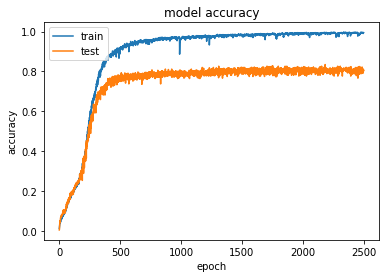

In [109]:
plt.plot(hist.history['my_accuracy_score'])
plt.plot(hist.history['val_my_accuracy_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

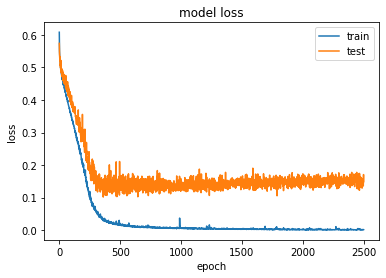

In [110]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Validando nos espectros criados com Penelope

57

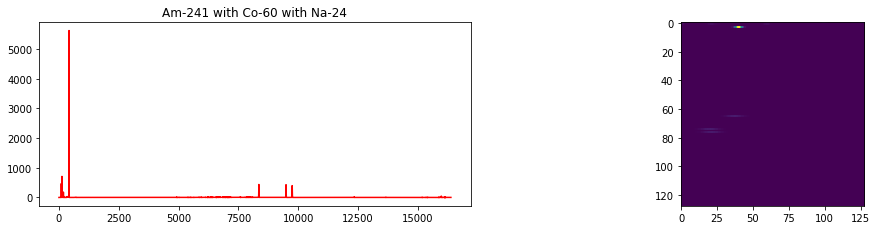

In [150]:
#x_, y_ = gerador_validacao[np.random.choice(len(gerador_validacao) - 1, 1)[0]]
idx = 0
f, axarr = plt.subplots(1, 2, figsize=(17, 1.7))
axarr[0].plot(range(len(x_[idx].reshape(-1))),
              x_[idx].reshape(-1), 'r')

axarr[0].set_title(" with ".join(binarizer.inverse_transform(np.array([y_[idx]]))[0]))
axarr[1].imshow(x_[0].reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [148]:
pred = model.predict(np.array([x_[idx].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':binarizer.classes_, 'score': pred[0]*100})
df

,radionuclideo,score
0,Am-241,100.0000%
1,Ba-133,0.0000%
2,Cd-109,0.0000%
3,Co-57,0.0000%
4,Co-60,99.9851%
5,Cs-137,0.0000%
6,Eu-152,0.0000%
7,Mn-54,0.0000%
8,Na-24,100.0000%
9,Pb-210,0.0000%


# Validando nos espectros experimentais

In [111]:
def obtem_dados_dos_canais(linhas):
    dados = []
    pode_comecar = False
    for linha in linhas:
        if linha == "A004USERDEFINED                                                     \n":
            pode_comecar = True
            continue
        if pode_comecar:
            aux = linha.strip().split()
            if int(aux[1]) % 5:
                print("oi!")
            dados.extend([float(x) for x in aux[2:]])
    return dados[1:]

In [112]:
arquivos = ['Am-241 - BG.IEC',
            'Ba-133 - BG.IEC',
            'Cd-109 - BG.IEC',
            'Co-57 - BG.IEC',
            'Co-60 - BG.IEC',
            'Cs-137 - BG.IEC',
            'Eu-152 - BG.IEC',
            'Mn-54 - BG.IEC',
            'Na-22 - BG.IEC',
            'Pb-210 - BG.IEC',]

df_nuclideos = dict()
img_espectros = dict()
img_convertidos = dict()
images = dict()

for arquivo in arquivos:
    print(arquivo)
    dados = []

    with open('/export/ipen/artigo/ICDA-3/Espectros/Experimentos/17-Maio-2018/Espectros/{0}'.format(arquivo), 'r') as f:
        dados = f.readlines()
    dados = obtem_dados_dos_canais(dados)
    df = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})
    df_nuclideos[arquivo] = df.copy()
    img_convertidos[arquivo] = np.array(dados).reshape((128, 128)).copy()
    images[arquivo.split(' ')[0]] = np.array(dados).reshape((128, 128)).copy()

Am-241 - BG.IEC
Ba-133 - BG.IEC
Cd-109 - BG.IEC
Co-57 - BG.IEC
Co-60 - BG.IEC
Cs-137 - BG.IEC
Eu-152 - BG.IEC
Mn-54 - BG.IEC
Na-22 - BG.IEC
Pb-210 - BG.IEC


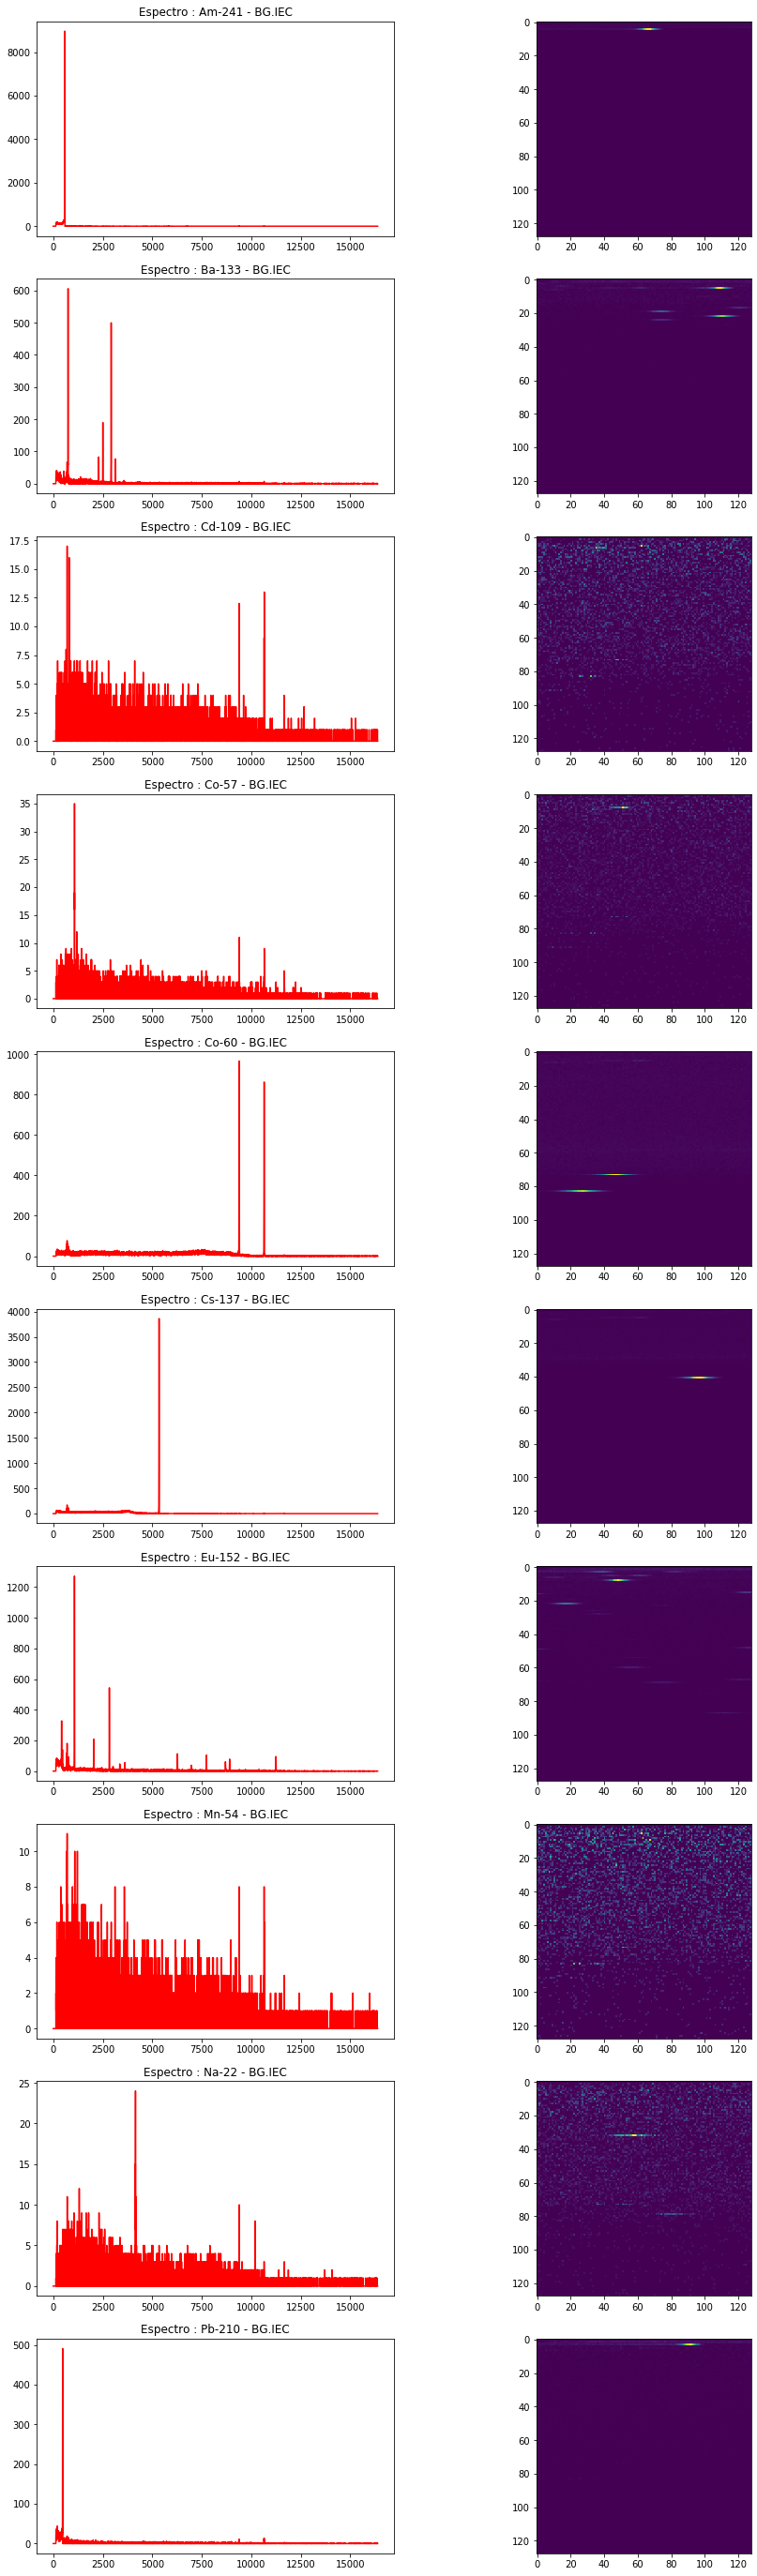

In [113]:
f, axarr = plt.subplots(10, 2, figsize=(15,25))
for n, arquivo in enumerate(arquivos):
    df = df_nuclideos[arquivo]
    axarr[n, 0].plot(df['channel'], df['counts'], 'r')
    axarr[n, 0].set_title("Espectro : {0}".format(arquivo))
    
    axarr[n, 1].imshow(img_convertidos[arquivo])
    #axarr[n, 1].set_title("Como Imagem : {0}".format(arquivo))
    
plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [114]:
pd.options.display.float_format = '{:,.4f}%'.format

In [115]:
pred = model.predict(np.array([images['Am-241'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':binarizer.classes_, 'score': pred[0]*100})
df

,radionuclideo,score
0,Am-241,100.0000%
1,Ba-133,0.0010%
2,Cd-109,100.0000%
3,Co-57,100.0000%
4,Co-60,0.0000%
5,Cs-137,0.0000%
6,Eu-152,0.0000%
7,Mn-54,0.0000%
8,Na-24,0.0000%
9,Pb-210,100.0000%


In [116]:
pred = model.predict(np.array([images['Ba-133'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':binarizer.classes_, 'score': pred[0]*100})
df

,radionuclideo,score
0,Am-241,100.0000%
1,Ba-133,100.0000%
2,Cd-109,100.0000%
3,Co-57,93.4709%
4,Co-60,0.0000%
5,Cs-137,0.0000%
6,Eu-152,0.0000%
7,Mn-54,0.0000%
8,Na-24,0.0000%
9,Pb-210,100.0000%


In [117]:
pred = model.predict(np.array([images['Cd-109'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':binarizer.classes_, 'score': pred[0]*100})
df

,radionuclideo,score
0,Am-241,97.9906%
1,Ba-133,0.0011%
2,Cd-109,0.0001%
3,Co-57,0.0000%
4,Co-60,0.0000%
5,Cs-137,0.0000%
6,Eu-152,0.0000%
7,Mn-54,0.0000%
8,Na-24,0.0000%
9,Pb-210,0.8266%


In [118]:
pred = model.predict(np.array([images['Co-57'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':binarizer.classes_, 'score': pred[0]*100})
df

,radionuclideo,score
0,Am-241,58.6660%
1,Ba-133,0.0101%
2,Cd-109,0.0096%
3,Co-57,0.0000%
4,Co-60,0.0000%
5,Cs-137,0.0000%
6,Eu-152,0.0000%
7,Mn-54,0.0000%
8,Na-24,0.0000%
9,Pb-210,0.4907%


In [95]:
pred = model.predict(np.array([images['Co-60'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':binarizer.classes_, 'score': pred[0]*100})
df

,radionuclideo,score
0,Am-241,8.0161%
1,Ba-133,0.3084%
2,Cd-109,5.1369%
3,Co-57,0.1023%
4,Co-60,0.4531%
5,Cs-137,0.3664%
6,Eu-152,99.9996%
7,Mn-54,0.4362%
8,Na-24,97.9868%
9,Pb-210,11.3421%


In [96]:
pred = model.predict(np.array([images['Cs-137'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':binarizer.classes_, 'score': pred[0]*100})
df

,radionuclideo,score
0,Am-241,19.8704%
1,Ba-133,11.2694%
2,Cd-109,5.7577%
3,Co-57,1.8994%
4,Co-60,0.0013%
5,Cs-137,100.0000%
6,Eu-152,0.0410%
7,Mn-54,0.1017%
8,Na-24,2.5232%
9,Pb-210,26.9434%


In [97]:
pred = model.predict(np.array([images['Eu-152'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':binarizer.classes_, 'score': pred[0]*100})
df

,radionuclideo,score
0,Am-241,99.9948%
1,Ba-133,2.6321%
2,Cd-109,80.6282%
3,Co-57,0.9852%
4,Co-60,0.0245%
5,Cs-137,1.7290%
6,Eu-152,27.0246%
7,Mn-54,0.3221%
8,Na-24,0.1521%
9,Pb-210,10.9352%


In [98]:
pred = model.predict(np.array([images['Mn-54'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':binarizer.classes_, 'score': pred[0]*100})
df

,radionuclideo,score
0,Am-241,14.6693%
1,Ba-133,0.4003%
2,Cd-109,19.0830%
3,Co-57,4.0665%
4,Co-60,0.0588%
5,Cs-137,4.8569%
6,Eu-152,0.2105%
7,Mn-54,1.3556%
8,Na-24,0.4618%
9,Pb-210,16.8123%


In [99]:
pred = model.predict(np.array([images['Na-22'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':binarizer.classes_, 'score': pred[0]*100})
df

,radionuclideo,score
0,Am-241,15.2255%
1,Ba-133,0.4059%
2,Cd-109,18.9759%
3,Co-57,3.8436%
4,Co-60,0.0599%
5,Cs-137,4.9466%
6,Eu-152,0.2237%
7,Mn-54,1.3673%
8,Na-24,0.4445%
9,Pb-210,16.6926%


In [100]:
pred = model.predict(np.array([images['Pb-210'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':binarizer.classes_, 'score': pred[0]*100})
df

,radionuclideo,score
0,Am-241,19.0769%
1,Ba-133,0.8071%
2,Cd-109,27.1257%
3,Co-57,81.8487%
4,Co-60,0.0343%
5,Cs-137,3.5983%
6,Eu-152,0.2280%
7,Mn-54,0.8621%
8,Na-24,0.4559%
9,Pb-210,16.8960%


## Fonte triplice de calibração

In [119]:
dados = []

with open('/export/ipen/artigo/ICDA-3/Espectros/Experimentos/17-Maio-2018/Espectros/Am-Cs-Co - BG.IEC', 'r') as f:
    dados = f.readlines()
dados = obtem_dados_dos_canais(dados)
df_triplice = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})

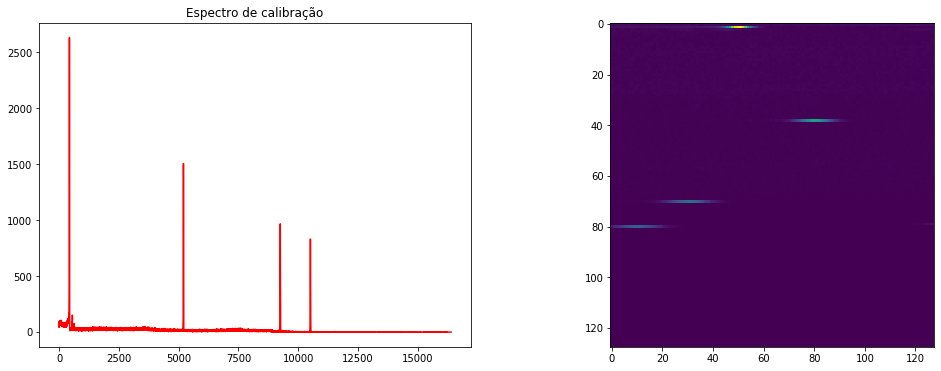

In [151]:
f, axarr = plt.subplots(1, 2, figsize=(17, 3))
axarr[0].plot(df_triplice['channel'], df_triplice.counts.shift(-145).fillna(0).values, 'r')
axarr[0].set_title("Espectro de calibração")
axarr[1].imshow(np.array(dados).reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [139]:
dados = df_triplice.counts.shift(-400).fillna(0).values
pred = model.predict(np.array([dados.reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':binarizer.classes_, 'score': pred[0]*100})
df

,radionuclideo,score
0,Am-241,100.0000%
1,Ba-133,0.0000%
2,Cd-109,100.0000%
3,Co-57,0.0000%
4,Co-60,0.0000%
5,Cs-137,0.0000%
6,Eu-152,20.5510%
7,Mn-54,1.1098%
8,Na-24,0.0000%
9,Pb-210,100.0000%
